# Initialize a fresh test data dir

Includes horiz and vertical symmetry manipulations

In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy import asarray
import h5py
from glob import glob
import json
import sys
import random
import cv2
import PIL
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
data_dir = './dcai_gcb_02/dcai_gcb_02'
train_dir = data_dir + '/train'
val_dir = data_dir + '/val'
numerals = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
vae_frac = 0.1
target_counts = {
    'i': 370,
    'ii': 592,
    'iii': 700,
    'iv': 1630,
    'v': 800,
    'vi': 900,
    'vii': 1500,
    'viii': 1500,
    'ix': 1500,
    'x': 500,
}
# print(sum(target_counts.values()))
# target_counts = {k: int((1-vae_frac)*v) for k, v in target_counts.items()}
print(sum(target_counts.values()))

9992


In [4]:
def get_file_count(numeral):
    num_pattern = data_dir + '/*/{}/*.png'.format(numeral)
    fps = glob(num_pattern)
    return len(fps)

def get_n_required(numeral):
    n_files = get_file_count(numeral)
    n_required = target_counts[numeral] - n_files
    if n_files > target_counts[numeral]:
        msg = ('Bad file count for {} with {} files and {} requested'
               .format(numeral, n_files, target_counts[numeral]))
        raise RuntimeError(msg)
    return n_required

def count_all_files():
    n_tot = 0
    for n in numerals:
        n_files = get_file_count(n)
        n_tot += n_files
        print('Numeral "{}" has {} files'.format(n, n_files))
    print('Total of {} files'.format(n_tot))

In [5]:
count_all_files()

Numeral "i" has 320 files
Numeral "ii" has 204 files
Numeral "iii" has 202 files
Numeral "iv" has 330 files
Numeral "v" has 243 files
Numeral "vi" has 232 files
Numeral "vii" has 247 files
Numeral "viii" has 256 files
Numeral "ix" has 278 files
Numeral "x" has 233 files
Total of 2545 files


In [6]:
def run(fp_source, fp_dest, 
        horiz=False, 
        vert=False, 
        rotate=False, 
        erode=False,
        dilate=False,
        enhance=1, 
        contrast=1, 
        resize=(32, 32), 
        show=False):
    
    image = Image.open(fp_source)
    image_out = Image.open(fp_source)
    
    if rotate == 'random':
        rotate = np.random.normal(0, 12)
    if enhance == 'random':
        enhance = np.random.normal(1, 0.5)
    if contrast == 'random':
        contrast = np.maximum(0.3, np.random.normal(1, 0.5))
    if erode == 'random':
        erode = np.random.choice([0, 1], 1)
    if dilate == 'random':
        dilate = np.random.choice([0, 1], 1)
        
    if horiz:
        arr = asarray(image_out)
        arr = arr[:, ::-1]  # horizontal sym
        image_out = Image.fromarray(arr)
    if vert:
        arr = asarray(image_out)
        arr = arr[::-1, :]  # vert sym
        image_out = Image.fromarray(arr)
    if rotate:
        image_out = image_out.rotate(rotate, PIL.Image.NEAREST, 
                                     expand=False, 
                                     fillcolor='white')
    if erode:
        kernel = np.ones((3, 3), np.uint8)
        arr_out = cv2.erode(asarray(image_out), kernel, iterations=1)
        image_out = Image.fromarray(arr_out)
    if dilate:
        kernel = np.ones((2, 2), np.uint8)
        arr_out = cv2.dilate(asarray(image_out), kernel, iterations=1)
        image_out = Image.fromarray(arr_out)

    image_out = image_out.resize(resize)

    image_out = ImageEnhance.Sharpness(image_out)
    image_out = image_out.enhance(enhance)
    image_out = ImageEnhance.Contrast(image_out)
    image_out = image_out.enhance(contrast)

    if show:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        ax1.imshow(image, cmap='binary_r')
        ax2.imshow(image.resize(resize), cmap='binary_r')
        ax3.imshow(image_out, cmap='binary_r')
        plt.show()
        plt.close()

    if fp_dest is not None:
        image_out.save(fp_dest)

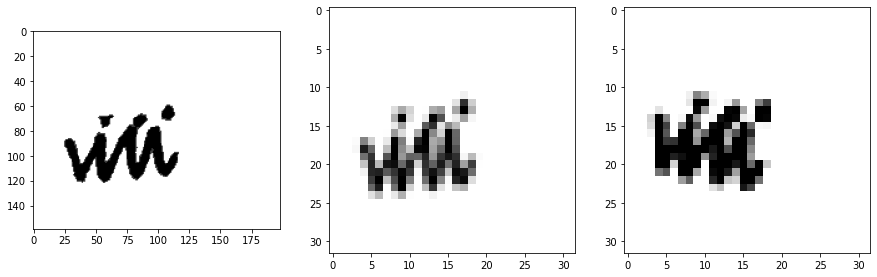

In [7]:
num = 'viii'
num_dir = data_dir + '/train/{}/*.png'.format(num)
fps = [fp for fp in glob(num_dir) if '_vert' not in fp and '_horiz' not in fp]
fp = fps[100]
fp_out = None
run(fp, fp_out, horiz=False, vert=False, 
    enhance='random', 
    contrast='random', 
    rotate='random', 
    erode='random', 
    dilate='random', 
    show=True)

In [8]:
ifile = 0
horiz_sym = ['i', 'ii', 'iii', 'x', 'v']
vert_sym = ['i', 'ii', 'iii', 'x', 'ix']
no_sym = ['vii', 'viii']

jobs = {
    'i': {'horiz': True, 'vert': True},
    'ii': {'horiz': True, 'vert': True},
    'iii': {'horiz': True, 'vert': True},
    'iv': {'horiz': False, 'vert': False, 'target': 'vi'},
    'v': {'horiz': True, 'vert': False},
    'vi': {'horiz': False, 'vert': False, 'target': 'iv'},
    'vii': {'horiz': False, 'vert': False},
    'viii': {'horiz': False, 'vert': False},
    'ix': {'horiz': False, 'vert': True},
    'x': {'horiz': True, 'vert': True},
}

In [9]:
for num, kwargs in jobs.items():
    n_required = get_n_required(num)
    num_dir = data_dir + '/train/{}/*.png'.format(num)
    fps = [fp for fp in glob(num_dir) if '_eng_' not in fp]
    ifps = np.random.choice(np.arange(len(fps)), n_required, replace=True)
    for i in ifps:
        fp = fps[i]
        
        if 'target' in kwargs:
            target = kwargs.pop('target')
            base_dir = os.path.dirname(fp).replace(num, target)
            fp_out = os.path.join(base_dir, '{}_eng_{}.png'.format(target, str(ifile).zfill(5)))
        else:
            base_dir = os.path.dirname(fp)
            fp_out = os.path.join(base_dir, '{}_eng_{}.png'.format(num, str(ifile).zfill(5)))
        
        run(fp, fp_out, 
            enhance='random', 
            contrast='random', 
            rotate='random', 
            erode='random', 
            dilate='random', 
            show=False, 
            **kwargs)
        ifile += 1

In [10]:
count_all_files()

Numeral "i" has 370 files
Numeral "ii" has 592 files
Numeral "iii" has 700 files
Numeral "iv" has 1630 files
Numeral "v" has 800 files
Numeral "vi" has 899 files
Numeral "vii" has 1500 files
Numeral "viii" has 1500 files
Numeral "ix" has 1500 files
Numeral "x" has 500 files
Total of 9991 files
